In [1]:
import numpy as np
import matplotlib.pyplot as plt
import elephant
import quantities as pq
import neo
import viziphant
import os

ModuleNotFoundError: No module named 'elephant'


## Overview: 
This jupyter noteboook is a basic python implementation of the SIMNETS neural analysis framework[1].
- A more versalite python implementation of SIMNETS can be found on the Donoghue/Vargas-Irwin lab GitHub Page, curtesy of Nicholas Tolley(github.io/ntolley)[3].
- For an C++ optimized Matlab toolbox, see [2] on the Donoghue/ Vargas-Irwin lab GitHub Page. 

#### WHAT
The SIMNETS analysis is an unsupervised method for generating and visualizing the latent network Computational Similarity (CS) relationships among a population of simultaneously recording individual neurons.  The document provides a comprehensive guide on the various steps involved in the most basic algorithmic implementation of the SIMNETS Analysis. The code can serve as a starting point for researchers interested in analyzing neural data and can be easily adapted to fit specific experimental paradigms. A faster python implementation with greater functionality may be found here: https://github.com/DonoghueLab/SIMNETS-Python.

#### WHY
As is demonstrated in this tutorial, the resulting low-dimensional CS maps of the population of neurons can facilitate the identification of CS neuron clusters, or putative computational subnetworks. These CS neurons maps are a powerful and efficient tool for conducing preliminary exploratory analyses within very large-scale neural recording datasets. For example, the Matlab toolbox can rapidly (milliseconds) separate (i.e., clusters) groups of noisy or uninformative neuron from those encoding useful neural signals.

#### STEPS
- Step 1: This code is organized into different sections, starting with setting up the necessary simulation parameters to create a small dataset of synthetic spike trains.

- Step 2: We then use a distance metric (victor purpura metric) to calculate the geometry of each neuron's spike train output space (i.e., its computational geometry or representational geometry). 

- Step 3: The neuron-wise Computational Similarity Scores are calculated for all NxN neuron pairs using Pearson's correlation (cons: linear method, sensitive to outliers).

- Step 4: The code then calculates low-dimensional projections of the NxN CS matrix using t-SNE, a non-linear  technique that preserves local neighborhood structure (as opposed to PCA which is a linear and global method). In our paper, we use PCA-intialized tSNE, which combines the best of both methods.  

- STEP 5: We then use the k-means clustering algorithm to identify clusters of computationally similar neurons. 

  #### In Progress... 
    - Step 6: Compute Time: run-time analysis with & without parallelization
    - Step 7: SIMNETS Vs. Cross-Correlation: similarities & differences



#### RESOURCES/CITATIONS

[1] Mapping the Computational Similarity of Individual neurons within large-scale ensemble recordings usingthe SIMNETS analysis framework. elife, Tools & Resources (in-review). Hynes, JB., Brand man, D., Zimmerman, J., Donoghue, J., Vargas-Irwin, C. doi: doi.org/10.1101/463364

[2] Matlab ToolBox: https://github.com/DonoghueLab/SIMNETS-Analysis-Toolbox 

[3] Python Toolbox(under development): https://github.com/DonoghueLab/SIMNETS-Python

[4] Elephant (doi:10.5281/zenodo.1186602; RRID:SCR_003833)
elephant electrophysiology analysistoolkit: a very useful and well-maintained codebase for analyzing neural data. Includes both classic signal processing tools/tutorials and more advanced neural analysis tools/tutorials. https://elephant.readthedocs.io/en/stable/tutorials/statistics.html 
www.python-elephant.org




##### Author: jacqueline_hynes@brown.edu, June 2023 
Contact: @author Jacqueline Hynes. Copyright (c) Jacqueline Hynes, Brown University. All rights reserved.
Questions? Contact <Carlos Vargas_irwin@brown.edu>  or <Jacqueline Hynes@Brown.edu>. We are happy to help with any trouble shooting or provide guidance on how to best analyze your own data.




### 1.0. Creating a dataset of synthetic spike trains
We start by setting up the necessary simulation parameters to create a small dataset of synthetic spike trains. These parameters include the number of neurons, the number of stimulus conditions, and the number of trials per stimulus condition. The current population of simulated neurons is designed to have K = 2 clusters of computationally distinct neurons (i.e., neurons 1-3 and neurons 4-6 are have different stimulus response profiles). These are also referred to as "cell assemblies" or "functional subnetworks", however, we use the phrase Computational Similarity subnetworks to differentiation between this method and classic functional connectivity methods (e.g., cross-correlation). 
- num_neurons: number of neurons in the test population
- num_trials_cond/num_trials: the code is currently set up to simulate 20 spike trains per neurons (5 repeats per   stimulus conditions)

We also set the parameters for the general SIMNETS analysis, which include:
- q: the VP spike train temporal accuracy settings 
- perp: the tSNE perplexity value, which is a parameter that defines a neuron's local neighbours



In [2]:
from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process
from quantities import ms, s, Hz
np.random.seed(28)  # to make the results reproducible


#1.0 Set-up parameters
win_start = 0        #  spike train start time 
win_stop = 1         # spike train length/ endtime

num_neurons = 6      # num neurons   
num_cond = 4         # stimulus condition
num_trials_cond = 5  # trials per stimulus condition

# These values specify each neuron's firing rates across the 'num_cond' conditions. 
rate_pop = [[70, 70, 70, 5],
            [30, 30, 30, 3], 
            [55, 55, 55, 3], 
            [10, 10, 30, 60], 
            [20, 20, 50, 80], 
            [15, 15, 25, 50]]
     
# Generate spike trains using encoding model of choice:
num_cond = len(rate_pop[0])
num_trials = num_trials_cond*num_cond
spks_population = []
spks_trials = []

for n in range(num_neurons):
    rate_ref = rate_pop[n]
    spks_trials = []
    
    for r in rate_ref:
        spks = [ homogeneous_poisson_process(rate=r*Hz, t_start=win_start*s, t_stop=win_stop*s) for i in range(num_trials_cond) ]
        spks_trials.append(spks) 
   
    spks_trials = np.array([spks_trials], dtype = object) 
    spks_trials = np.resize(spks_trials, (num_trials,))
    spks_population.append(spks_trials)

spks_population = np.array(spks_population)
print(f'neurons & trials {spks_population.shape}')     # Population: [rows, cols]  = [neurons, trials] 
print(f'trials per neuron {spks_population[0].shape}') # Single neuron: [rows, cols]  = [neurons, trials] 
 

 

ModuleNotFoundError: No module named 'elephant'

In [3]:
# Plot single neuron raster plots for the synthetic data
fig1, axs = plt.subplots(1,num_neurons, figsize=(7,3))
fig1.set_figwidth(15) 
plt.figure(dpi=500)
axs[0].set_ylabel('spktrain index') 
 
for n in range(num_neurons):
    
    # Plot Single Neuron Raster Plots 
    axs[n].eventplot([st.magnitude for st in spks_population[n]], linelengths=0.75, linewidths=1, color='black')
    axs[n].set_xlabel('time (s)') 
    axs[n].set_title('n' + str(int(n+1))) 

NameError: name 'num_neurons' is not defined

### 2.0.  Generate a Single Neuron Spike train Similarity Matrix (SSIM matrix) for each neuron. 
We then use a distance metric (Victor Purpura metric) to calculate the pairwise spike train similarities among the spike trains of each neuron. Each neuron's SxS matrix of spiketrain distances capture the geometry of each neurons output space, i.e., the computational geometry or representational geometry. 


In [4]:
import neo
from elephant.spike_train_dissimilarity import victor_purpura_distance

q = 10/ (10.0 * pq.ms)  # Temporal accuracy of Victor-Purpura similarity metric
print(q)


ssimdist_pop = []
spkdist_vec = [] 
for n in range(num_neurons):
    
    spkdist_vec = []
    for sx in range(num_trials):
        
        for sy in range(num_trials):   
                
            spkdist = victor_purpura_distance([spks_population[n,sx], spks_population[n,sy]], q, algorithm='fast')[0, 1]
            spkdist_vec.append(spkdist)      
    ssimdist_pop.append(spkdist_vec)
       
ssimdist_pop = np.array(ssimdist_pop) 
print(ssimdist_pop.shape)

ModuleNotFoundError: No module named 'neo'

In [5]:
# Plotting: Single neuron rasters and Single neuron ssim matrices
fig2, axs = plt.subplots(2,num_neurons, figsize=(7,4))
fig2.set_figwidth(15) 
plt.figure(dpi=500)

for n in range(num_neurons):
    
    # Plot Single Neuron Raster Plots 
    axs[0,n].eventplot([st.magnitude for st in spks_population[n]], linelengths=0.75, linewidths=0.75, color='black')
    axs[0,n].set_xlabel('time (s)') 
    axs[0,n].set_title('n' + str(int(n+1))) 
    
    # Plot Single Neuron Raster Plots 
    ssimMat = np.reshape(ssimdist_pop[n], [num_trials, num_trials])
    axs[1,n].imshow(ssimMat)     
     
axs[0,0].set_ylabel('spktrain index') 
axs[1,0].set_ylabel('spktrain index')
axs[1,0].set_xlabel('spktrain index')

NameError: name 'num_neurons' is not defined

### STEP 3/4: Measure the pairwise CS score among all neurons to generate a NxN CS matrix for the neuron population, then use tSNE the generate low-dimension projects of the high-dimensional,  NxN CS matrix.

Neuron similarity: The neuron-wise Computational Similarity Scores are calculated for all NxN pairs of neurons. Any neuron similarity metric/measure can be used to assess the similarities of the neuron SSIM matrices. Here we use Pearson's correlation as our measure of Computational Similarity, however, many different measures are appropriate.
- Pearson's r:
    - Pros: fast/efficient; 
    - Cons: a sensitivity to outliers; it is a linear method and will not capture non-linear relationships among the neurons SSIM matrices.
    
Dimensionality Reduction: The code then calculates low-dimensional projections of the NxN CS matrix using t-SNE, a popular technique for visualizing high-dimensional data.


    

In [6]:
from elephant.spike_train_correlation import correlation_coefficient
import scipy.stats
from sklearn.manifold import TSNE



perp = num_neurons//2   # Perplexity value for tSNE (i.e., # of neurons within a local neighbourbood)



# STEP 3: We calculate the Computational Similarity between all NxN neurons:
cs_matrix = []
for nx in range(num_neurons):
    
    for ny in range(num_neurons):
        r = scipy.stats.pearsonr(ssimdist_pop[nx,:],ssimdist_pop[ny,:])
        cs_matrix.append(r.correlation)

cs_matrix = np.resize(cs_matrix, (num_neurons,num_neurons))
print(cs_matrix.shape)


# STEP 4:  We calculate the low-dimensional projections of the NxN CS matrix
tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=500)
cs_lowdim = tsne.fit_transform(cs_matrix)




ModuleNotFoundError: No module named 'elephant'

### Step 4:  plotting 

[]

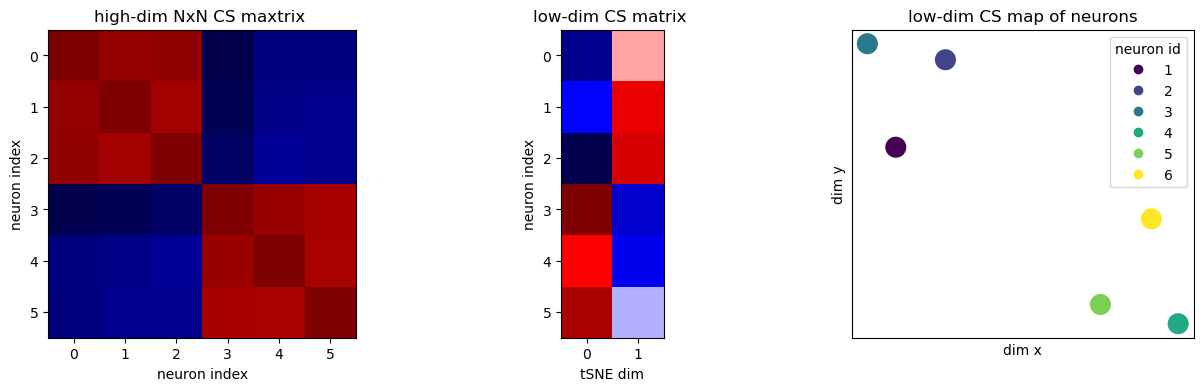

<Figure size 3200x2400 with 0 Axes>

In [7]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import seaborn as sns
import pandas as pd


# DataFrame: create data stuctures to faciliate plotting 
neuronid = np.array(list(range(num_neurons)))+1
neuroncluster_str = ['clu1', 'clu2', 'clu...']
dfmap = pd.DataFrame(cs_lowdim, columns = ['dim-x', 'dim-y'], index= neuronid )


# PLOTTING: Figure 3

# imshow plot - high-dim CS matrix
fig3, axs3 = plt.subplots(1,3, figsize=(7,4))
fig3.set_figwidth(15) 
plt.figure(dpi=500)

axs3[0].imshow(cs_matrix, cmap='seismic' )  
axs3[0].set_ylabel('neuron index') 
axs3[0].set_xlabel('neuron index') 
axs3[0].set_title ('high-dim NxN CS maxtrix ')

# imshow plot -  low-dim CS matrix 
axs3[1].imshow(cs_lowdim, cmap='seismic' )  
axs3[1].set_xlabel('tSNE dim') 
axs3[1].set_ylabel('neuron index') 
axs3[1].set_title ('low-dim CS matrix ')

# scatter plot- low-dim CS map 
scatterFig = axs3[2].scatter(dfmap['dim-x'], dfmap['dim-y'], c=neuronid, s=200)
axs3[2].legend(*scatterFig.legend_elements(), loc = 'best', title="neuron id")                      
  
axs3[2].set_xlabel('dim x')
axs3[2].set_ylabel('dim y')
axs3[2].set_title ('low-dim CS map of neurons')
axs3[2].set_xticks([])
axs3[2].set_yticks([])





## STEP 5: subnetwork detection with k-means clustering. 

#### CS neuron cluster detection (i.e., putative cell assemblies or subnetworks).  
We then use the k-means clustering algorithm to assign neurons into k number of clusters, where the value of k is usually specified a priori.  Typically, the true number of neuron cluster within the neuron map is unknown and cluster validation tools are used to generate a best guess. Typically, we use a  silhouette anlaysis, combined with our novel shuffle-based conditional resampling statistical test, to determine the optimal value for k, however, for brevity, we will pre-select k as 2. 


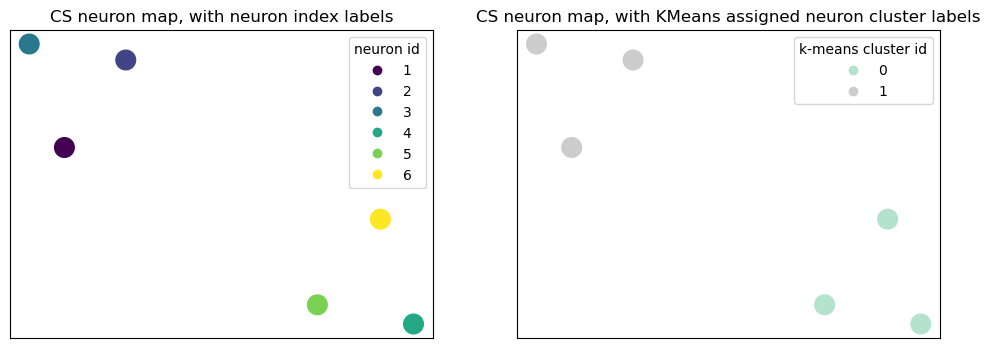

<Figure size 3200x2400 with 0 Axes>

In [8]:
from sklearn.cluster import KMeans

# STEP 5:  use kmeans to assign cluster labels to neurons 

k_select = 2  # kmeans take a cluster number as an input. We have prior knowledge on ground-truth num of clusters 

kmeans_output = KMeans(n_clusters=k_select, random_state=0, n_init="auto").fit(cs_lowdim)



# PLOTTING
dfmap_kmeans = pd.DataFrame(cs_lowdim, columns = ['dim-x', 'dim-y'], index= kmeans_output.labels_ )

# Figure 4
fig4, axs4 = plt.subplots(1,2, figsize=(7,4))
fig4.set_figwidth(12) 
plt.figure(dpi=500)

# scatter plot - CS map, neuron index labels
scatterFig1 = axs4[0].scatter(dfmap['dim-x'], dfmap['dim-y'], c=neuronid, s=200)
                     
axs4[0].set_title ('CS neuron map, with neuron index labels')
axs4[0].set_xticks([])
axs4[0].set_yticks([])
axs4[0].legend(*scatterFig.legend_elements(), loc = 'best', title="neuron id") 



# scatter plot - CS map,  KMeans cluster labels
scatterFig2 = axs4[1].scatter(dfmap_kmeans['dim-x'], dfmap['dim-y'], 
                              c=kmeans_output.labels_, s=200, cmap=plt.colormaps['Pastel2'])

axs4[1].set_title ('CS neuron map, with KMeans assigned neuron cluster labels' )
axs4[1].set_xticks([]) 
axs4[1].set_yticks([])
axs4[1].legend(*scatterFig2.legend_elements(), loc = 'best', title="k-means cluster id")  




In [14]:
print(st_data)

[[array([0.00678803, 0.05531244, 0.10686933, 0.13102868, 0.14231465,
       0.21395218, 0.21808661, 0.28449002, 0.34718226, 0.42331601,
       0.61059048, 0.63052796, 0.75079855, 0.75956431, 0.80689777,
       0.95054896, 1.02316791, 1.05653811, 1.11946997, 1.43761985,
       1.46189278, 1.63138179, 1.65859164, 1.78893735, 1.90560058,
       2.14220489, 2.23791395, 2.24200359, 2.28538871, 2.35745105,
       2.39872087, 2.60643735, 2.7465338 , 2.76704979, 2.77151215,
       2.80050985, 2.83230935, 2.87747013, 3.31616743, 3.55101504,
       3.57319813, 3.74368205, 3.97293078, 4.51113264, 4.53999473,
       4.61399799, 4.64259874, 4.66685575, 4.68948022, 4.72856905,
       4.74899494, 4.93704203]), array([0.22632122, 0.32934901, 0.33841393, 0.42376924, 0.52463699,
       0.62903233, 0.87821369, 0.96293122, 1.0048658 , 1.08534985,
       1.34941072, 1.36200279, 1.55867049, 1.72225674, 1.80440316,
       1.9419469 , 2.23964517, 2.26119802, 2.26258123, 2.43055319,
       2.48104595, 2.502868